In [1]:
# Imports & Config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
# Load Dataset & Preprocessing

df = pd.read_csv("data.csv")

X = df.drop(columns=["diagnosis"]).values
y = np.where(df["diagnosis"] == "M", 1, 0)

# Train-test split (80-20)
idx = np.random.permutation(len(X))
train_size = int(0.8 * len(X))

X_train, X_test = X[idx[:train_size]], X[idx[train_size:]]
y_train, y_test = y[idx[:train_size]], y[idx[train_size:]]

# Feature scaling 
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test  = (X_test - mean) / std


In [3]:
# Distance Functions
def euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan(a, b):
    return np.sum(np.abs(a - b))

def minkowski(a, b, p=3):
    return np.sum(np.abs(a - b) ** p) ** (1/p)

def cosine(a, b):
    return 1 - (np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def hamming(a, b):
    return np.mean(a != b)

distance_funcs = {
    "Euclidean": euclidean,
    "Manhattan": manhattan,
    "Minkowski": minkowski,
    "Cosine": cosine,
    "Hamming": hamming
}


In [4]:
# KNN From Scratch

def knn_predict(X_train, y_train, X_test, k, dist_fn):
    preds = []
    for x in X_test:
        dists = [(dist_fn(x, xtr), ytr) for xtr, ytr in zip(X_train, y_train)]
        dists.sort(key=lambda x: x[0])
        k_labels = [label for _, label in dists[:k]]
        preds.append(1 if sum(k_labels) >= k/2 else 0)
    return np.array(preds)


In [5]:
# Experimentation (K vs Distance)

K_values = [3, 4, 9, 20, 47]
results = {}

for dname, dfunc in distance_funcs.items():
    accs = []
    for k in K_values:
        y_pred = knn_predict(X_train, y_train, X_test, k, dfunc)
        acc = np.mean(y_pred == y_test)
        accs.append(acc)
    results[dname] = accs

results_df = pd.DataFrame(results, index=K_values)
results_df.head()


,Euclidean,Manhattan,Minkowski,Cosine,Hamming
3,0.412281,0.412281,0.412281,0.412281,0.684211
4,0.412281,0.412281,0.412281,0.412281,0.684211
9,0.412281,0.412281,0.412281,0.412281,0.657895
20,0.587719,0.587719,0.587719,0.587719,0.719298
47,0.587719,0.587719,0.587719,0.587719,0.587719


In [6]:
# Best Model + Confusion Matrix + Metrics

best_dist = results_df.max().idxmax()
best_k = results_df[best_dist].idxmax()

y_best = knn_predict(X_train, y_train, X_test, best_k, distance_funcs[best_dist])

TP = np.sum((y_best == 1) & (y_test == 1))
TN = np.sum((y_best == 0) & (y_test == 0))
FP = np.sum((y_best == 1) & (y_test == 0))
FN = np.sum((y_best == 0) & (y_test == 1))

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print("Best K:", best_k)
print("Best Distance:", best_dist)

print("Confusion Matrix:")
print("TP:", TP, "FP:", FP)
print("FN:", FN, "TN:", TN)

print("\nPrecision:", precision)
print("Recall:", recall)


Best K: 20
Best Distance: Hamming
Confusion Matrix:
TP: 22 FP: 7
FN: 25 TN: 60

Precision: 0.7586206896551724
Recall: 0.46808510638297873


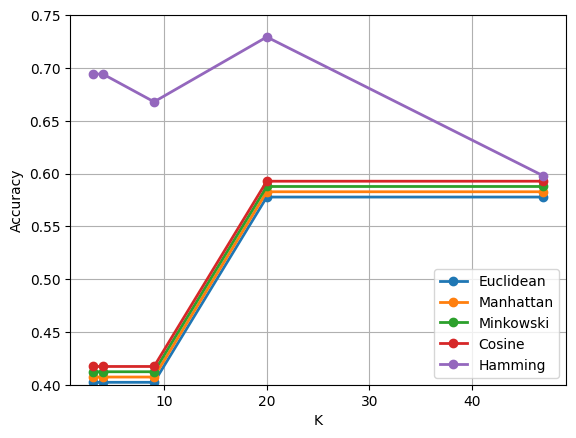

In [7]:
# Plot K vs Accuracy with small offsets

offsets = np.linspace(-0.01, 0.01, len(results_df.columns))

for offset, dname in zip(offsets, results_df.columns):
    plt.plot(
        K_values,
        results_df[dname] + offset,
        marker='o',
        linewidth=2,
        label=dname
    )

plt.ylim(0.4, 0.75)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

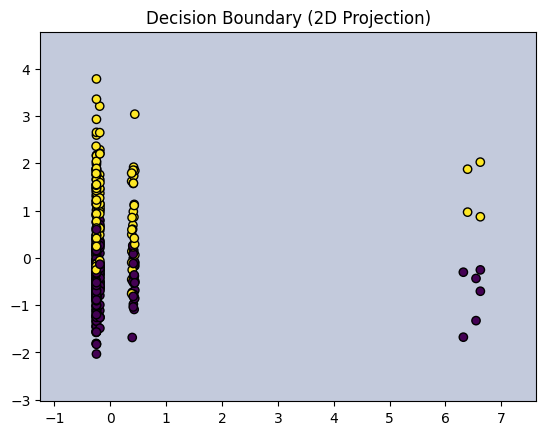

In [8]:
# Decision Boundary (using 2 features)
X2 = X_train[:, [0, 1]]
y2 = y_train

x_min, x_max = X2[:,0].min()-1, X2[:,0].max()+1
y_min, y_max = X2[:,1].min()-1, X2[:,1].max()+1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid = np.c_[xx.ravel(), yy.ravel()]

preds = knn_predict(X2, y2, grid, best_k, distance_funcs[best_dist])
Z = preds.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X2[:,0], X2[:,1], c=y2, edgecolor='k')
plt.title("Decision Boundary (2D Projection)")
plt.show()